# Gradient descent module

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
plt.style.use('seaborn-v0_8')

# from numba import jit

# Gradient descent 

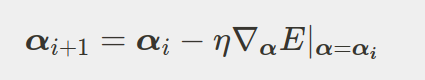

In [5]:
# @jit
def gradientDescentFunction(monteCarloIntegrationFunc, 
                            function, 
                            learning_rate: float , 
                            samples: np.ndarray, 
                            parameters: list, 
                            tolerance = 0.01, 
                            maximumSteps: int = 500, 
                            showEvolution: bool = False, 
                            wantEvolution: bool = False, 
                            printGradient: bool = False 
                           ) -> list : 
    
    '''
    Gradient descent function for updating parameters for one step. 
    
    Parameters
    ---------
        monteCarloIntegrationFunc: monte carlo integration function in functions_module.ipynb
    
        function: supposed to be local energy function 
        
        learning_rate: step size for descent 
        
        samples: metropolis samples from metropolisSamplingFunction
        
        parameters: list of parameters in floats 
        
        tolerance: how much you want gradient to be close enough to zero 
        
        maximumSteps: maximum steps to optimize the parameters. To avoid divergence situation, set some number to avoid infinite loops. 
        
        showEvolution: whether to plot parameters history 
        
        wantEvolution: if true, then the history of the parameters will be returned 
        
    Return
    ------
        list of optimized parameters in floats 
        
        if wantEvolution=True, then parameters history will be returned 
    '''
    
    # parameters as np.ndarray 
    parameters_array = np.array(parameters).copy()
    
    gradient = gradient_AtAPoint(monteCarloIntegrationFunc = monteCarloIntegrationFunc, 
                                 function=function, 
                                 samples=samples, 
                                 parameters=list(parameters_array), 
                                 nPointDifference=5)
    gradient = np.array(gradient) # transform to np.ndarray 
    
    
    
    # record all parameters points 
    parametersHistoryArraylist = []
    
    
    counter = 0 
    while np.any(gradient > tolerance): 
        
        # print counter
        print(counter, end = '\r')
        # print gradient to output
        if printGradient == True: 
            print('Gradient:', gradient)

        # gradient descent 
        parameters_array = parameters_array + learning_rate*gradient 
        gradient = np.array(  
                        gradient_AtAPoint(monteCarloIntegrationFunc = monteCarloIntegrationFunc, 
                                          function=function, 
                                          samples=samples, 
                                          parameters=list(parameters_array), 
                                          nPointDifference=2)
                    )
        
        
        # record parameters' history if want plotting or want history of the parameters in optimization
        if showEvolution or wantEvolution: 
            # record parameters 
            if counter == 0:  # create slots and append initial values 
                for i in range(len(parameters_array)): 
                    parametersHistoryArraylist.append([parameters_array[i]])
            elif counter >0 :   # appending when lists for values are already initialized
                for i in range(len(parameters_array)): 
                    parametersHistoryArraylist[i].append(parameters_array[i])
            else: 
                raise Exception('Error: Something is wrong with the counter')
    
    
        
        
        
        # breaking the loop mechanism 
        counter +=1 
        if counter >= maximumSteps: 
            break 
        
    
   # plot parameters 
    if showEvolution and (len(parametersHistoryArraylist)>0): 
        plotParameters(parametersArraylist=parametersHistoryArraylist)
    elif showEvolution and (len(parametersHistoryArraylist)<=0): 
        raise Exception('Parameters history is empty')
    
    
    # return evolution of the parameters 
    if wantEvolution: 
        return parametersHistoryArraylist
    

    
    
    return list(parameters_array)
    
    
    

# Visualization 

In [6]:
def plotParameters(parametersArraylist: list ) -> None: 
    '''
    For plotting parameters in gradientDescentFunction
    
    Parameters
    ---------
        parametersArraylist:
            parameters array as as list of list. Each row in the array presents one parameter's evolution in optimization 
            
    Returns 
    -------
        plot the parameters on the same plot 
    
    '''
    numberOfParameters = len(parametersArraylist) 
    
    steps = len(parametersArraylist[0])  # number of steps used to optimize parameters 
    
    for i in range(numberOfParameters): 
        if steps == len(parametersArraylist[i]): 
            plt.plot(range(steps), parametersArraylist[i], marker ='.', linestyle ='-', ms= 10 )
        else:  
            raise Exception("Error in plotting: Number of steps and parametersArraylist's length is not compatible")
    
    
    

# Numerical derivative

## Gradient at the point 

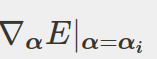

In [7]:
# @jit
def gradient_AtAPoint(monteCarloIntegrationFunc, function, samples: np.ndarray, parameters: list, nPointDifference: int,  h: float=0.0001 ) -> list  : 
    '''
    Compute gradient at point defined by parameters 
    
    Parameters
    ---------
        monteCarloIntegrationFunc: monte carlo integration function in functions_module.ipynb
    
        function: supposed to be local energy function 
        
        
        h: step size used in finite difference method 
        
        samples: metropolis samples from metropolisSamplingFunction
        
        parameters: list of parameters in floats 
        
        nPointDifference: 2 or 5 point difference method
                    
        
        
    Return
    ------
        gradient as list. E.g. [Dx F, Dy F, Dz F]|x=x0, y=y0, z=z0 (partial derivative of F with respect to x at point x_0, etc. )
    '''
    
    numberOfParameters = len(parameters) 
    
    
    
    
    # perform n point difference methods
    if nPointDifference == 2: 
        gradient = [   twoPointDiff(monteCarloIntegrationFunc = monteCarloIntegrationFunc,function= function, h = h, samples=samples, parameters=parameters, whichParameter=i)  for i in range(numberOfParameters) ]
    elif nPointDifference ==5: 
        gradient = [   fivePointDiff(monteCarloIntegrationFunc = monteCarloIntegrationFunc, function= function, h = h, samples=samples, parameters=parameters, whichParameter=i)  for i in range(numberOfParameters) ]
    else: 
        raise Exception('Derivative method does not exits!')
    
    
    return gradient 

## Five point difference 

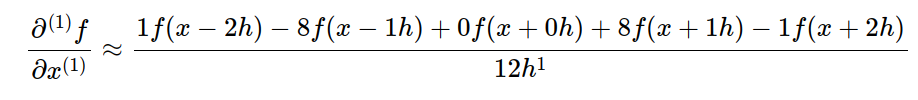

In [8]:
# @jit
def fivePointDiff(monteCarloIntegrationFunc, function, h: float, samples: np.ndarray, parameters: list, whichParameter: int  ) -> float : 
    
    '''
    Five point finite difference 
    
    Parameters
    ---------
    
        monteCarloIntegrationFunc: monte carlo integration function in functions_module.ipynb
    
        function: supposed to be local energy function 
        
        h: step size used in finite difference method 
        
        samples: metropolis samples from metropolisSamplingFunction
        
        parameters: list of parameters in floats 
        
        whichParameter: 
            index number specifying to which parameter you are taking the derivative. 
            e.g. derivative with respect to first parameter in the parameters list, whichParameter = 0 
                    
        
        
    Return
    ------
        the derivative approximation as number 
    '''
     # make copy of the original arrays and preparing to minus or plus h 
    parameters_array_plusH = np.array(parameters).copy()  
    parameters_array_minusH = np.array(parameters).copy() 

    parameters_array_plus2H = np.array(parameters).copy()  
    parameters_array_minus2H = np.array(parameters).copy() 
    
    parameters_array_plusminus0H = np.array(parameters).copy()  

    
    # add/substract h from the n-th parameter 
    parameters_array_plusH[whichParameter] += h 
    parameters_array_minusH[whichParameter] -= h 
    
    # add/substract 2*h from the n-th parameter 
    parameters_array_minus2H[whichParameter] -= 2*h  
    parameters_array_plus2H[whichParameter] += 2*h 
    

    
    
    numerator = (  monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_minus2H) - 
                 8* monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_minusH) + 
                8* monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_plusH) -
                monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_plus2H)    )
    
    denominator = 12*h 
    
    return numerator/denominator

## Two point difference 

$$\frac{f(x+h)- f(x-h)}{2h }$$

In [9]:
# @jit
def twoPointDiff(monteCarloIntegrationFunc, function, h: float, samples: np.ndarray, parameters: list, whichParameter: int  ) -> float : 
    '''
    Two point finite difference 
    
    Parameters
    ---------
        monteCarloIntegrationFunc: monte carlo integration function in functions_module.ipynb
    
        function: supposed to be local energy function 
        
        h: step size used in finite difference method 
        
        samples: metropolis samples from metropolisSamplingFunction
        
        parameters: list of parameters in floats 
        
        whichParameter: 
            index number specifying to which parameter you are taking the derivative. 
            e.g. derivative with respect to first parameter in the parameters list, whichParameter = 0 
                    
        
        
    Return
    ------
        the derivative approximation as number 
    '''
    
     # make copy of the original arrays and preparing to minus 
    parameters_array_plusH = np.array(parameters).copy()  
    parameters_array_minusH = np.array(parameters).copy() 
    
    # add/substract h from the n-th parameter 
    parameters_array_plusH[whichParameter] += h 
    parameters_array_minusH[whichParameter] -= h 
    
    numerator = (  monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_plusH) -    
                 monteCarloIntegrationFunc(samples= samples, localEnergyFunction=function, params=parameters_array_minusH)     )
    
    denominator = 2*h 
    
    return numerator/denominator